In [ ]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("gorororororo23/armenian-coins-data")

path = os.path.join(path, "Armenian Coins")
path = os.path.join(path, "data")
folders = os.listdir(path)

print("Carpetas dentro del dataset:")
for folder in folders:
    print(folder)

Carpetas dentro del dataset:
500dram
100dram
20dram
50dram
200dram
10dram


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Capa convolucional 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Capa convolucional 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Capa convolucional 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(-1, 128 * 16 * 16)

        x = F.relu(self.fc1(self.dropout(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
from collections import defaultdict
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import kagglehub
import os

# Transformación para convertir imágenes a RGB (3 canales)
class ConvertToRGB:
    def __call__(self, img):
        if img.mode in ("P", "RGBA"):
            img = img.convert("RGBA")
            if img.mode == "RGBA" and img.info.get("transparency", None) is not None:
                return img
            else:
                return img.convert("RGB")
        return img

mean = [0.485, 0.456, 0.406]  # Media para los canales RGB
std = [0.229, 0.224, 0.225]   # Desviación estándar para los canales RGB

# Transformaciones para el entrenamiento
train_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomResizedCrop((256, 256),
                                 scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transformaciones para test
test_transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


# Carga del dataset
path = kagglehub.dataset_download("gorororororo23/armenian-coins-data")
dataset_path = os.path.join(path, "Armenian Coins")
dataset_path = os.path.join(dataset_path, "data")
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

# Agrupar las imágenes por clase y división del dataset en 80%-20%
class_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset.samples):
    class_to_indices[label].append(idx)

#
train_indices, test_indices = [], []

for cls, indices in class_to_indices.items():
    np.random.shuffle(indices)  # Mezclar índices para cada clase
    split = int(0.8 * len(indices))  # Dividir 80% train, 20% test
    train_indices.extend(indices[:split])
    test_indices.extend(indices[split:])

# Crear subconjuntos para entrenamiento y prueba para pasarlos a los dataloaders
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
print(f"Clases detectadas: {train_subset.dataset.classes}")

# Inicializar el modelo, criterio de pérdida y optimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = ConvNet().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Clases detectadas: ['100dram', '10dram', '200dram', '20dram', '500dram', '50dram']
Using device: cuda


In [ ]:
import torch

# Entrenamiento
epochs = 30
train_loss = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))

    # Evaluación en el conjunto de validación
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss.append(val_running_loss / len(test_loader))
    accuracy = correct / total
    val_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}, Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Accuracy: {accuracy:.4f}')


Epoch 1, Loss: 0.7445, Val Loss: 1.7572, Val Accuracy: 0.2083
Epoch 2, Loss: 0.0897, Val Loss: 0.3578, Val Accuracy: 0.8667
Epoch 3, Loss: 0.0406, Val Loss: 0.0485, Val Accuracy: 0.9917
Epoch 4, Loss: 0.0194, Val Loss: 0.0137, Val Accuracy: 1.0000
Epoch 5, Loss: 0.0142, Val Loss: 0.0079, Val Accuracy: 1.0000
Epoch 6, Loss: 0.0118, Val Loss: 0.0058, Val Accuracy: 1.0000
Epoch 7, Loss: 0.0093, Val Loss: 0.0049, Val Accuracy: 1.0000
Epoch 8, Loss: 0.0031, Val Loss: 0.0059, Val Accuracy: 1.0000
Epoch 9, Loss: 0.0039, Val Loss: 0.0016, Val Accuracy: 1.0000
Epoch 10, Loss: 0.0073, Val Loss: 0.0023, Val Accuracy: 1.0000
Epoch 11, Loss: 0.0050, Val Loss: 0.0030, Val Accuracy: 1.0000
Epoch 12, Loss: 0.0056, Val Loss: 0.0036, Val Accuracy: 1.0000
Epoch 13, Loss: 0.0142, Val Loss: 0.0010, Val Accuracy: 1.0000
Epoch 14, Loss: 0.0067, Val Loss: 0.0006, Val Accuracy: 1.0000
Epoch 15, Loss: 0.0037, Val Loss: 0.0006, Val Accuracy: 1.0000
Epoch 16, Loss: 0.0023, Val Loss: 0.0010, Val Accuracy: 1.0000
E

<ipython-input-16-824a555f4ab3>:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


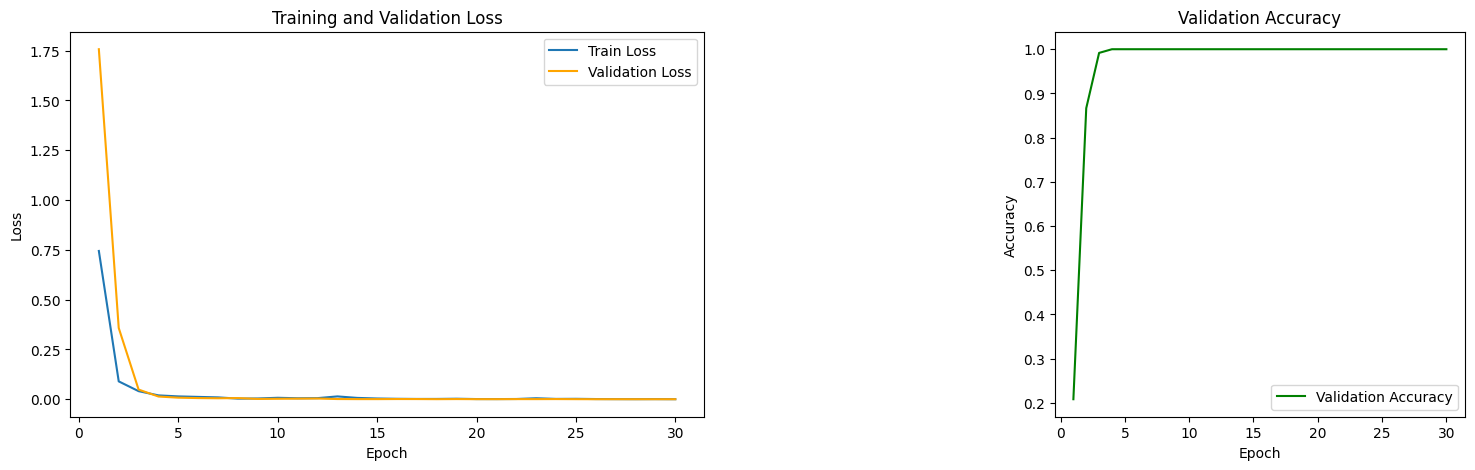

La precisión del modelo es del: 100.00%


<Figure size 800x800 with 0 Axes>

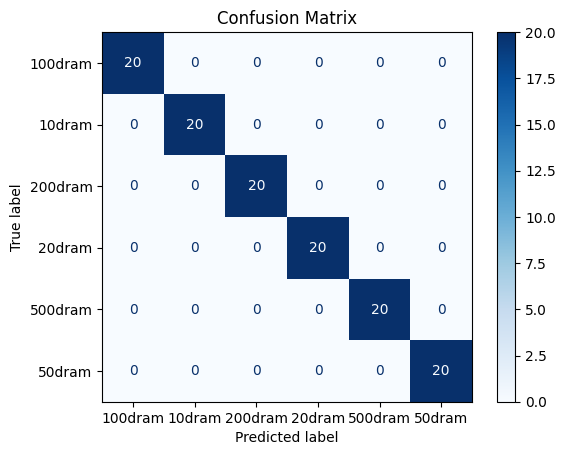

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


plt.figure(figsize=(18, 5))

# Val_loss y train_loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# PVal_Acuraccy
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Val_Accuracy del modelo
correct = 0
total = 0
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'La precisión del modelo es del: {100 * (correct / total):.2f}%')


# Visualización de la matriz de confusión
class_names = train_subset.dataset.classes
cm = confusion_matrix(all_labels, all_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 8))
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

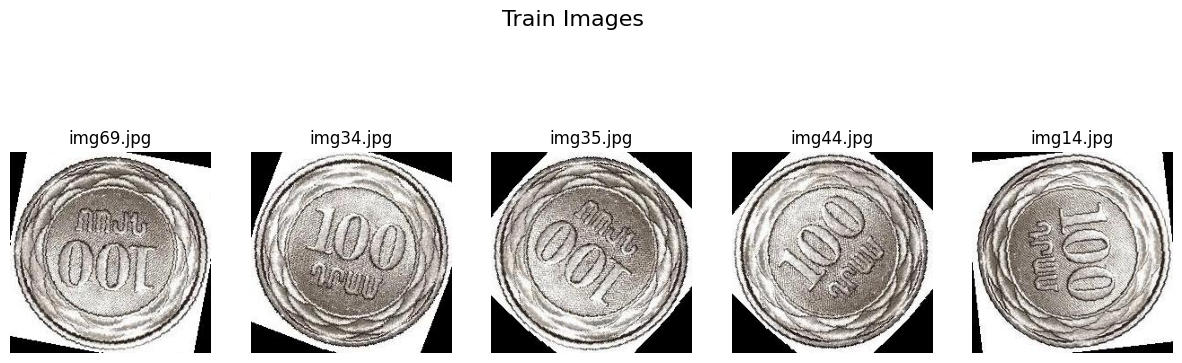

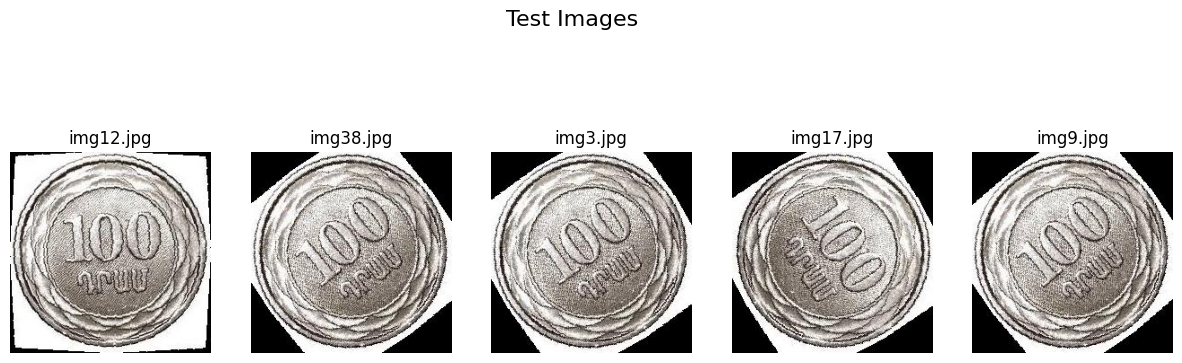

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Mostrar imágenes de train y test
def show_images(dataset, indices, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i, idx in enumerate(indices[:num_images]):
        img_path = dataset.dataset.samples[idx][0]
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(img_path))

# Visualizar ejemplos de train y test
show_images(train_subset, train_indices, "Train Images")
show_images(test_subset, test_indices, "Test Images")
